# **Range Azimuth**

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, '..')
from utils.radar_params import *

%matplotlib inline

In [3]:
DATA_PATH = "../indoor_sample_50.h5"
CONFIG_PATH = "/home/iberrios/Documents/datasets/radical/data/radarcfg/indoor_human_rcs.cfg"

In [4]:
import h5py

data_dict = {}
with h5py.File(DATA_PATH, 'r') as h5_obj:

    for key in h5_obj.keys():
        print(key, 'shape: ', h5_obj[key].shape)
        data_dict.update({key : np.asarray(h5_obj[key])})

depth shape:  (50, 720, 1280)
depth_timestamp shape:  (50, 1)
radar shape:  (50, 32, 8, 304)
radar_timestamp shape:  (50, 1)
rgb shape:  (50, 720, 1280, 3)
rgb_timestamp shape:  (50, 1)


In [5]:
adc_data = data_dict['radar'][28, ...]

## Process Range-Doppler

In [6]:
# perform Fast Time Range FFT
range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

# perform Slow Time Doppler FFT
range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

### Get Range and Velocity values

In [7]:
with open(CONFIG_PATH, 'r') as f:
    for line in f.readlines():
        if 'profileCfg' in line:
            line = line.split(' ')

            start_freq = float(line[2]) # GHz
            idle_time = float(line[3]) # usec
            ramp_end_time = float(line[5]) # usec
            chirp_slope = float(line[8]) # MHz/usec
            num_adc_samples = float(line[10]) # unitless
            adc_sample_rate = float(line[11]) # Msps

        elif 'channelCfg' in line:
            line = line.split(' ')

            # number of receive antennas
            rx_bin = bin(int(line[1])).zfill(4)
            num_rx = len([i for i in rx_bin if i == '1'])

            # number of transmit antennas
            tx_bin = bin(int(line[2])).zfill(4)
            num_tx = len([i for i in tx_bin if i == '1'])


print(f"Number of Rx Antennas: {num_rx}")
print(f"Number of Tx Antennas: {num_tx}")
print(f"Start Frequency: {start_freq} GHz")
print(f"Idle Time: {idle_time} usec")
print(f"Ramp End Time: {ramp_end_time} usec") # this should really be called ramp to end? or maybe just chirptime?
print(f"Chirp Slope: {chirp_slope} MHz/usec")
print(f"Number of ADC Samples: {num_adc_samples}")
print(f"ADC sample rate: {adc_sample_rate} Msps")

Number of Rx Antennas: 4
Number of Tx Antennas: 2
Start Frequency: 77.0 GHz
Idle Time: 58.0 usec
Ramp End Time: 40.0 usec
Chirp Slope: 100.0 MHz/usec
Number of ADC Samples: 304.0
ADC sample rate: 9499.0 Msps


In [8]:
range_resolution, bandwidth = compute_range_resolution(adc_sample_rate, num_adc_samples, chirp_slope)
max_range = range_resolution * num_adc_samples

range_resolution, max_range

(0.04683764076549342, 14.23864279271)

In [9]:
num_chirps = adc_data.shape[0]
chirp_interval = (ramp_end_time + idle_time) * 1e-6 # usec

doppler_resolution = compute_doppler_resolution(num_chirps, bandwidth, chirp_interval, num_tx)
max_doppler = doppler_resolution * num_chirps / 2

doppler_resolution, max_doppler

(0.3040613230233833, 4.864981168374133)

Get ranges

In [11]:
ranges = np.arange(0, max_range + range_resolution, range_resolution)

range_ticks = np.arange(0, len(ranges), len(ranges)//10)
range_tick_labels = ranges[::len(ranges)//10].round(2)

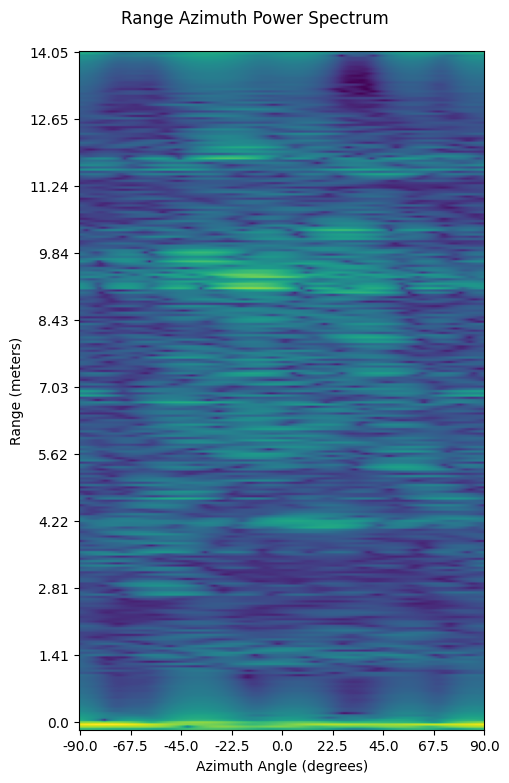

In [12]:
# zero pad along the antennas
range_doppler_padded = np.pad(range_doppler, pad_width=[(0, 0), (86, 87), (0, 0)], mode='constant')

# perform FFT over azimuth 
az_fft = np.fft.fftshift(np.fft.fft(range_doppler_padded, axis=1), axes=1)

# Compute Power Spectrum
az_power = np.abs(az_fft)**2
beamformed_img = np.flipud(np.mean(az_power, axis=2))

# # display
# plt.figure(figsize=(5, 10))
# plt.imshow(np.log(beamformed_img))
# plt.show();

fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(np.log(beamformed_img));
fig.suptitle("Range Azimuth Power Spectrum");
ax.set_xlabel("Azimuth Angle (degrees)");
ax.set_ylabel("Range (meters)");

# apply Range and Doppler labels
ax.set_yticks(range_ticks, range_tick_labels[::-1]);

ax.set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

#### Helper Functions

In [13]:
def forward_backward_avg(Rxx):
    """ Performs forward backward averaging on the given input square matrix
    Args:
        Rxx (ndarray): A 2D-Array square matrix containing the covariance matrix for the given input data
    Returns:
        R_fb (ndarray): The 2D-Array square matrix containing the forward backward averaged covariance matrix
    """
    assert np.size(Rxx, 0) == np.size(Rxx, 1)

    # --> Calculation
    M = np.size(Rxx, 0)  # Find number of antenna elements
    Rxx = np.matrix(Rxx)  # Cast np.ndarray as a np.matrix

    # Create exchange matrix
    J = np.eye(M)  # Generates an identity matrix with row/col size M
    J = np.fliplr(J)  # Flips the identity matrix left right
    J = np.matrix(J)  # Cast np.ndarray as a np.matrix

    R_fb = 0.5 * (Rxx + J * np.conjugate(Rxx) * J)

    return np.array(R_fb)


def aoa_capon(x, a):
    """ Computes Capon Spectrum
        Inputs:
            x - output of 1D range FFT (v_rtx, num_chirps)
            a - steering vector (num_angles, v_rtx)
        Outputs:
            capon_spectrum - Computed Capon Spectrum (num_angles)
    """
    # perturbation
    p = np.eye(x.shape[0]) * 1e-9

    Rxx = x @ np.conj(x).T
    Rxx = forward_backward_avg(Rxx)

    Rxx_inv = np.linalg.inv(Rxx + p)

    capon_spec = np.reciprocal(np.einsum('ij,ij->i', a.conj(), (Rxx_inv @ a.T).T))
    
    return capon_spec


def compute_steering_vector(num_ant=8, angle_res=1, angle_rng=90):
    """ Computes array of Steering Vectors for a desired angluar range
        and resolution. **This is a special function that only computes the
        steering vectors along a 1D linear axis.**
        Inputs:
            angle_res - angle resolution in degrees
            angle_rng - single sided angle range
            num_ant - number of virtual antennas
        Output:
            steering_vectors
    """
    # get number of steering vectors based on desired angle range and resolution
    num_vec = (2 * angle_rng / angle_res + 1)
    num_vec = int(round(num_vec))

    # convert to radians
    angle_rng = angle_rng*np.pi/180
    angle_res = angle_res*np.pi/180

    # compute steering vectors
    steering_vectors = np.zeros((num_vec, num_ant), dtype=np.complex64)
    for k in range(num_vec):
        for m in range(num_ant):
            steering_vectors[k, m] = np.exp(-1j*np.pi*m
                                            *np.sin(-angle_rng + k*angle_res))
            
    return steering_vectors


## Steering Vector

The Steering Vector describes the relative phase delay that each antenna element experiences. Consider the Uniform Linear Array below





Now let's derive the 1D steering vector for an array with elements spaced a half wavelength apart, we also assume that the broadside axis is the x-axis such that $\phi = 0$ so we only consider angle $\theta$. Each element pattern $W_i(\theta)$, notice that the array **element** pattern is distinclty different than the *array pattern* $W(\theta)$. The element pattern is a property of the antenna element itself, while the array pattern (or array factor) is dependent on both the geometry of the array and the amplitude and phase of each element.


The epxression $\bar{a}(\theta)$ is the steering vector for angle $\theta$, which represents the phase delays at each element $i$, the phase delays are characterized by the time delay $\Tau_i$ at each element. This is the time delay that enables the array to pass or reject plane waves at certain orientations.
$$
\begin{align*}

    a_i(\theta) &= \frac{1}{N} W_i(\theta) exp\left(-j \omega \Tau_i \right)
    \\
    &= \frac{1}{N} W_i(\theta) exp\left(-j \omega (\bar{\alpha} \cdot \bar{x}_i) \right) \qquad \Tau = \bar{\alpha} \cdot \bar{x}
    \\
    &= \frac{1}{N} W_i(\theta) exp\left(-j (\bar{k} \cdot \bar{x}_i) \right) \qquad \alpha = \frac{1}{\omega} \bar{k} \cdot \bar{x}
    \\
    &= \frac{1}{N} W_i(\theta) exp\left(-j \frac{2 \pi}{\lambda} sin(\theta) (i d) \right) \qquad \text{1D assumption } \hat{x} \text{ direction only}
    \\
    &= \frac{1}{N} W_i(\theta) exp\left(-j \frac{2 \pi}{\lambda} \frac{\lambda}{2} i sin(\theta) \right) \qquad \text{half wavelength spacing}
    \\
    &= \frac{1}{N} W_i(\theta) exp\left(-j (\pi \, i \, sin(\theta) \right))
    
\end{align*}
$$

#### Derive the steering vector for 1D ULA along x-axis with half wavelength spacing and isotropic radiation patterns


[Wavevector](https://www.antenna-theory.com/definitions/wavevector.php) $k = (k_x, k_y, k_z)$

Element Position $r_m = (x_m, y_m, z_m)$ with $m$ total positions


$$

\begin{align*}

    v_m(k) &= exp(-j k \cdot r_m)
    \\
    &= exp( -j (k_x, k_y, k_z) \cdot (x_m, y_m, z_m))
    \\
    &= exp( -j (k_x, k_y, k_z) \cdot (x_m, y_m, z_m))
    \\
    &= exp( -j k_x x_m) \qquad \text{ Only x-axis is valid}
    \\
    &= exp \left( -j \frac{2 \pi}{\lambda} sin(\theta) x_m \right)
    \\
    &= exp \left( -j \frac{2 \pi}{\lambda} sin(\theta) m \frac{\lambda}{2} \right) \qquad \text{ Half wave-length spacing, so each } x_i \text{ is } \frac{\lambda}{2}
    \\
    &= exp \left( -j \, \pi \, m \, sin(\theta) \right)

\end{align*}
$$

With the derived Steering Vector formula above, we can compute Steering Values? for any arbitray angle $\theta$ at any antenna element $m$. 

In [14]:
steering_vector = compute_steering_vector(num_ant=8, angle_res=1.0, angle_rng=90)
steering_vector.shape

(181, 8)

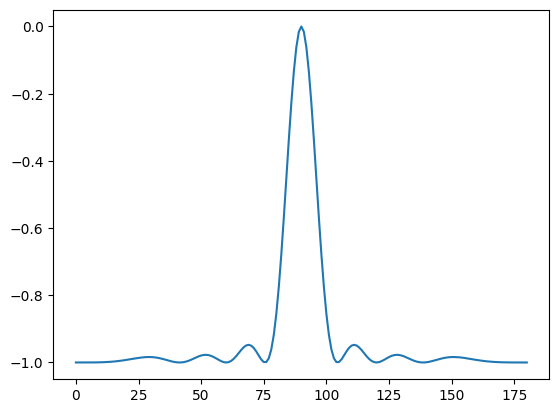

In [27]:
plt.plot(-np.abs(steering_vector[:, :].std(axis=1))**2)

In [15]:
np.fft.fft(range_doppler, axis=0).shape

(304, 8, 32)

In [32]:
n_range_bins = range_doppler.shape[0]
n_angles = steering_vector.shape[0]

range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)

for i in range(range_doppler.shape[0]):
    range_azimuth[i,:] = aoa_capon(range_doppler[i, ...], steering_vector)

range_azimuth = np.flipud(np.fliplr(range_azimuth))

#### Display Azimuth Spectrum

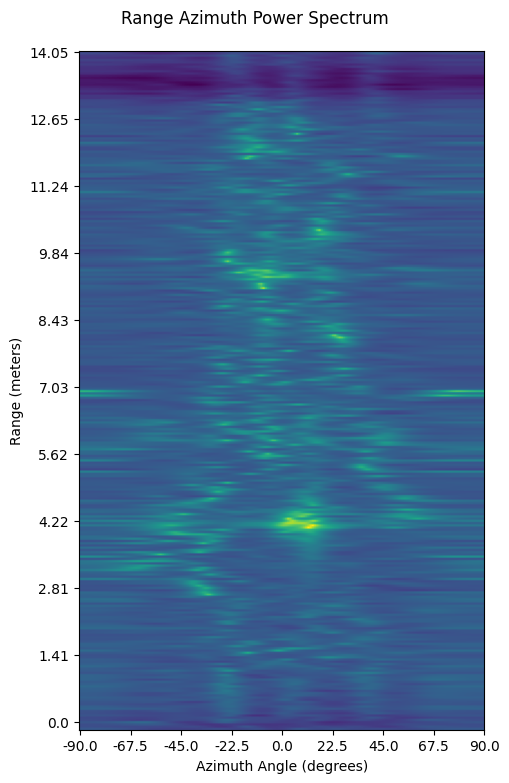

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 8))
ax.imshow(10*np.log10(np.abs(range_azimuth)));
fig.suptitle("Range Azimuth Power Spectrum");
ax.set_xlabel("Azimuth Angle (degrees)");
ax.set_ylabel("Range (meters)");

# apply Range and Doppler labels
ax.set_yticks(range_ticks, range_tick_labels[::-1]);

ax.set_xticks(np.linspace(0, 181, 9), np.linspace(-90, 90, 9).round(1));

plt.tight_layout();

## Make Video

This time, we will include the RGB images so we can really see what's going on

In [84]:
import cv2


frames = []

for i in range(len(data_dict['radar'])):

    # get raw ADC data
    adc_data = data_dict['radar'][i, ...]

    # perform Fast Time Range FFT
    range_cube = np.fft.fft(adc_data, axis=2).transpose(2, 1, 0)

    # perform Slow Time Doppler FFT
    range_doppler = np.fft.fftshift(np.fft.fft(range_cube, axis=2), axes=2)

    # compute Capon Spectrum
    range_azimuth = np.zeros((n_range_bins, n_angles), dtype=np.complex64)

    for j in range(range_doppler.shape[0]):
        range_azimuth[j,:] = aoa_capon(range_doppler[j, ...], steering_vector)

    range_azimuth = 20*np.log10(np.abs( np.flipud(np.fliplr(range_azimuth)) ))

    # convert to normalized uint8 to save with opencv video writer
    range_azimuth = cv2.normalize(range_azimuth, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    range_azimuth = range_azimuth[:, :, None].repeat(3, axis=2) # make 3 channel


    # obtain rgb image and resize
    rgb = data_dict['rgb'][i, ...]
    ih, iw = rgb.shape[:2]
    iw2, ih2 = int(iw/2.361), int(ih/2.361)

    rgb = cv2.resize(rgb, (iw2, ih2))
    bgr = cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR)

    zero_pad = np.zeros((ih2, 2, 3), dtype=np.uint8)

    frame = np.hstack((rgb, zero_pad, range_azimuth))

    # append frame to list
    frames.append(frame)


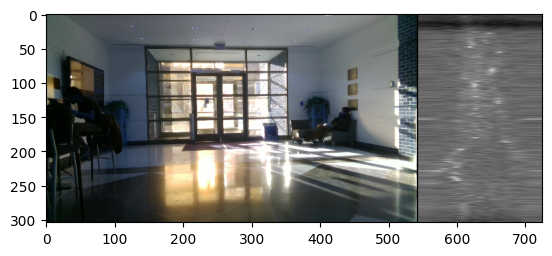

In [85]:
plt.imshow(frame);

In [90]:
h, w = frame.shape[:2]

out = cv2.VideoWriter("../videos/range_azimuth.avi",
                      cv2.VideoWriter_fourcc(*'DIVX'), # *'mp4v' *'MJPG' *'h264' *'x264' *'DIVX'
                      3,
                      (w, h))

for frame in frames:
    out.write(frame)

out.release()
del out